# Modelling

This is the second notebook of our project. Previously in the first notebook, we discussed our problem statement, followed by data cleaning and exploratory data analysis on the train dataset.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_curve,average_precision_score, PrecisionRecallDisplay, auc

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Functions

In [3]:
def append_results(result, train_score, metric, classifier):
    tmp = pd.DataFrame({
        'model':classifier,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        'pr_score':metric[metric['metric'] == 'pr_score']['score'].values[0],
        #'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [4]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    pr_score = average_precision_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc,
        'pr_score':pr_score
    }
    fig, axes = plt.subplots(ncols=3, figsize=(17,5))
    
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d', ax=axes[0]);
    axes[0].title.set_text('Confusion Matrix')
    # cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['WNV Not Present (0)','WNV Present (1)'], ax=axes[0]);
    roc_curve = plot_roc_curve(classifier, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
    axes[1].title.set_text('ROC AUC Curve Chart')
    precision, recall, thresholds = precision_recall_curve(y, classifier.predict_proba(X)[:,1])
    pr_curve = PrecisionRecallDisplay(precision=precision, recall=recall)#(classifier, X, y, ax=axes[2])
    pr_curve.plot(ax=axes[2])
#    axes[2].plot([min(thresholds),max(thresholds)], [min(thresholds),max(thresholds)], label='threshold', linestyle='--')
    axes[2].plot([0, 1], [0.5, 0.5],label='baseline', linestyle='--' )
    axes[2].title.set_text('PR Curve')
    fig.tight_layout()
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values()
        })
    return metrics

In [5]:
def output_results(preds, filename):
    preds_to_df = pd.DataFrame(preds, columns=['0','1'])
    preds_to_df.drop('0',axis=1, inplace=True)
    preds_to_df.rename(columns={'1':'Wnvpresent'}, inplace=True)
    preds_to_df.index.rename('id', inplace=True)
    preds_to_df.index += 1
    preds_to_df.to_csv(f'./assets/{filename}.csv', index=True)

# Reading Data and Preprocessing

In [6]:
train_comb = pd.read_csv('./assets/train_comb.csv')

In [7]:
train_comb['date'] = pd.to_datetime(train_comb['date'])
train_comb.set_index('date', inplace=True)

In [8]:
X = train_comb.drop(columns=['wnvpresent'])
y = train_comb['wnvpresent']

In [9]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [10]:
# Scale X data
ss = StandardScaler()
Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

## Baseline Score

In [11]:
train_comb['wnvpresent'].value_counts(normalize=True)

0    0.944966
1    0.055034
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.945. We note from our target column: `wnvpresent` that there is massive class imbalance between the presence and absence of the West Nile Virus. We can utilise SMOTE to generate new instances in the minority class during modelling. We will include SMOTE in the pipeline for each of our models.

In [12]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'test_accuracy',
    'misclassification',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'roc_auc',
    'pr_score'
])

## Logistic Regression

In [13]:
# instantiate pipeline
pipe_logreg = Pipeline([('sampling', SMOTE(random_state=100)),
                ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [14]:
# set params to gridsearch
# pipe_logreg_params = {
#     'logreg__penalty': ['l1','l2'],
#     'logreg__C': [0.5, 1, 1.5, 2],
#     'sampling__sampling_strategy': ['not majority','auto'],
#     'sampling__k_neighbors': [3, 5],
# }


pipe_logreg_params = {
    'logreg__penalty': ['l1'],
    'logreg__C': [10,20,30],
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [13],
    
}

In [15]:
gs_logreg = GridSearchCV(pipe_logreg, pipe_logreg_params,verbose=2, n_jobs=-1)

In [16]:
%%time
gs_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 9.65 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [10, 20, 30], 'logreg__penalty': ['l1'],
                         'sampling__k_neighbors': [13],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             verbose=2)

In [17]:
gs_logreg.best_params_

{'logreg__C': 30,
 'logreg__penalty': 'l1',
 'sampling__k_neighbors': 13,
 'sampling__sampling_strategy': 'auto'}

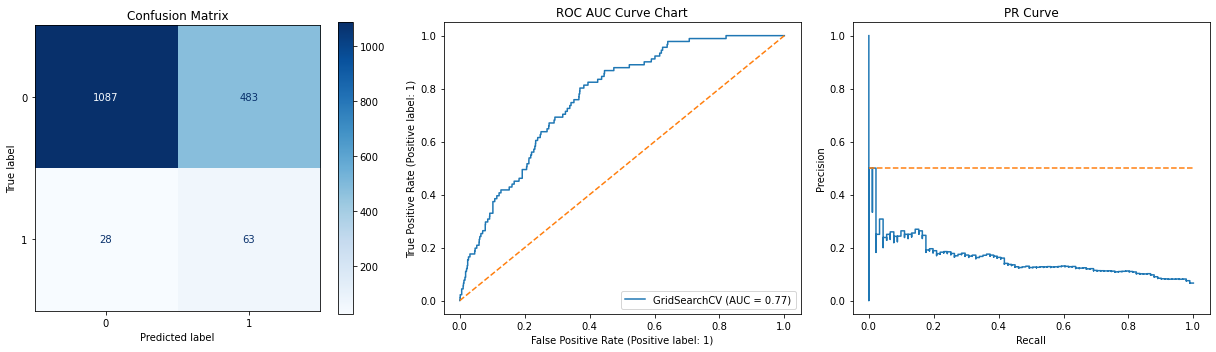

In [18]:
mod_metrics = metrics_and_plot_cm(gs_logreg, Xs_val, y_val)

In [19]:
results_df = append_results(results_df,
                           gs_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'Logistic Regression'
                           )

In [20]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646


## SVM

In [21]:
# instantiate pipeline
pipe_svc = Pipeline([('sampling', SMOTE(random_state=100)),
                 ('svc', SVC(probability=True, random_state=100))
                    ])

In [22]:
# pipe_svc_params = {
#     'svc__C': [5, 7, 9],
#     'svc__kernel': ['rbf'],  #'poly'
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],      
# }

pipe_svc_params = {
    'svc__C': [5],
    'svc__kernel': ['rbf'], 
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [3],
}

In [23]:
gs_svc = GridSearchCV(pipe_svc, pipe_svc_params, verbose=2, n_jobs=-1)

In [24]:
%%time
gs_svc.fit(Xs_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 41.5 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [3],
                         'sampling__sampling_strategy': ['auto', 'minority'],
                         'svc__C': [5], 'svc__kernel': ['rbf']},
             verbose=2)

In [25]:
gs_svc.best_params_

{'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'auto',
 'svc__C': 5,
 'svc__kernel': 'rbf'}

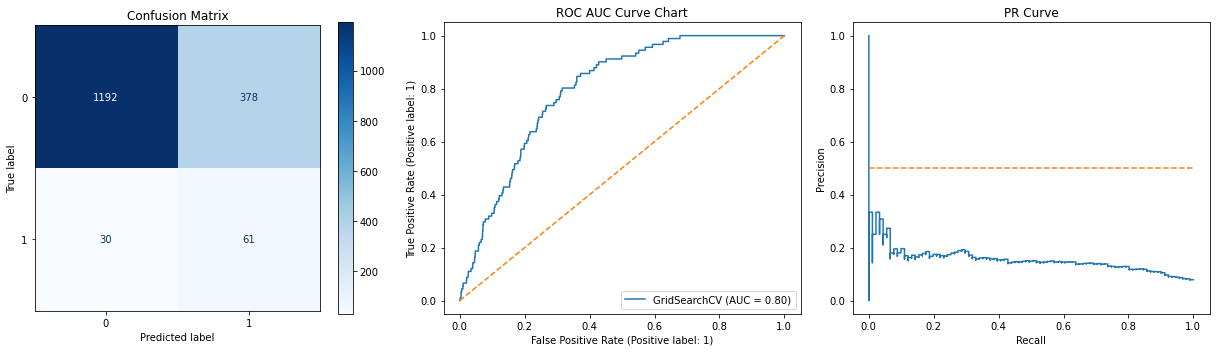

In [26]:
mod_metrics = metrics_and_plot_cm(gs_svc, Xs_val, y_val)

In [27]:
results_df = append_results(results_df,
                           gs_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'SVM',
                           )

In [28]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646
1,SVM,0.787747,0.754365,0.245635,0.670330,0.759236,0.138952,0.230189,0.795898,0.154321


## PCA

In [29]:
# instantiate pca
pca = PCA(random_state=100)
pca.fit(Xs_train)

PCA(random_state=100)

In [30]:
pca.explained_variance_ratio_.round(6)[:22].sum()

0.999849

In [31]:
pca.explained_variance_ratio_.round(6)[:23].sum()

1.0

The first 23 components explain 100% of the variance. This is further found to be true when we run GridSearch of `n_components`, where 23 was found to be the optimal amount.

### Logistic Regression with PCA

In [32]:
# embed pca in a pipeline
pipe_pca_logreg = Pipeline([('sampling', SMOTE(random_state=100)),
                 ('pca', PCA(random_state=100)),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [33]:
# pipe_pca_logreg_params = {
#     'logreg__penalty': ['l1','l2'],
#     'logreg__C': [1, 1.5, 2],
#     'pca__n_components': [21,22,23,24],
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],
# }

pipe_pca_logreg_params = {
    'logreg__penalty': ['l1'],
    'logreg__C': [1],
    'pca__n_components': [23],
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [3],
}

In [34]:
gs_pca_logreg = GridSearchCV(pipe_pca_logreg, pipe_pca_logreg_params, verbose=2, n_jobs=-1)

In [35]:
%%time
gs_pca_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 335 ms


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('pca', PCA(random_state=100)),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l1'],
                         'pca__n_components': [23],
                         'sampling__k_neighbors': [3],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             verbose=2)

In [36]:
gs_pca_logreg.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l1',
 'pca__n_components': 23,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'auto'}

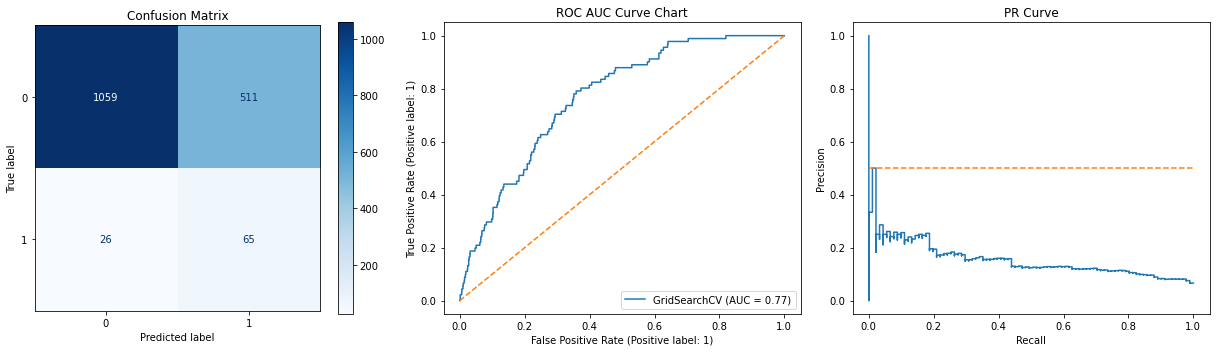

In [37]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [38]:
results_df = append_results(results_df,
                           gs_pca_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA Logistic Regression',
                           )

In [39]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646
1,SVM,0.787747,0.754365,0.245635,0.670330,0.759236,0.138952,0.230189,0.795898,0.154321
2,PCA Logistic Regression,0.691254,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268


### SVM with PCA

In [40]:
pipe_pca_svc = Pipeline([('sampling', SMOTE(random_state=100)),
                 ('pca', PCA(random_state=100)),
                 ('svc', SVC(probability=True, random_state=100))
])

In [41]:
# pipe_pca_svc_params = {
#     'svc__C': [5, 7, 9],
#     'svc__kernel': ['rbf'],  # 'poly'
#     'pca__n_components': [20, 30, 40],
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],      
# }

pipe_pca_svc_params = {
    'svc__C': [5],
    'svc__kernel': ['rbf'],  # 'poly'
    'pca__n_components': [23],
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [3],      
}

In [42]:
gs_pca_svc = GridSearchCV(pipe_pca_svc, pipe_pca_svc_params, verbose=2, n_jobs=-1)

In [43]:
%%time
gs_pca_svc.fit(Xs_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 41.7 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('pca', PCA(random_state=100)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [23],
                         'sampling__k_neighbors': [3],
                         'sampling__sampling_strategy': ['auto', 'minority'],
                         'svc__C': [5], 'svc__kernel': ['rbf']},
             verbose=2)

In [44]:
gs_pca_svc.best_params_

{'pca__n_components': 23,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'auto',
 'svc__C': 5,
 'svc__kernel': 'rbf'}

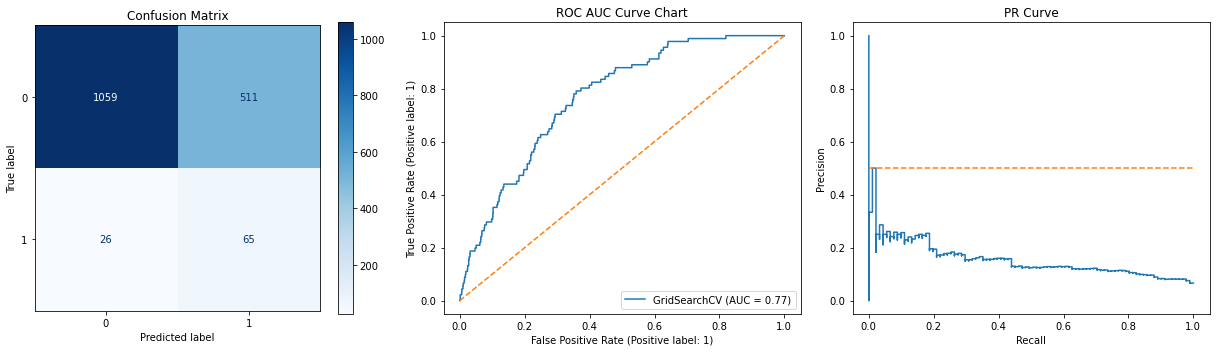

In [45]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [46]:
results_df = append_results(results_df,
                           gs_pca_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA SVM',
                           )

In [47]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646
1,SVM,0.787747,0.754365,0.245635,0.670330,0.759236,0.138952,0.230189,0.795898,0.154321
2,PCA Logistic Regression,0.691254,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268
3,PCA SVM,0.787897,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268


## AdaBoost

To remove as it's not the best performing classifier.

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [49]:
pipe_ada = Pipeline([
    ('sampling', SMOTE(random_state=100)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100), random_state=100))
])

In [50]:
# pipe_ada_params = {
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],  
#     'ada__n_estimators': [50,100,150],
#     'ada__learning_rate': [0.1,1,10]
# }

pipe_ada_params = {
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [5],  
    'ada__n_estimators': [100],
    'ada__learning_rate': [10]
}

In [51]:
gs_ada = GridSearchCV(pipe_ada, pipe_ada_params, verbose=1, n_jobs=-1)

In [52]:
gs_ada.fit(Xs_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100),
                                                           random_state=100))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [10], 'ada__n_estimators': [100],
                         'sampling__k_neighbors': [5],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             verbose=1)

In [53]:
gs_ada.best_params_

{'ada__learning_rate': 10,
 'ada__n_estimators': 100,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'auto'}

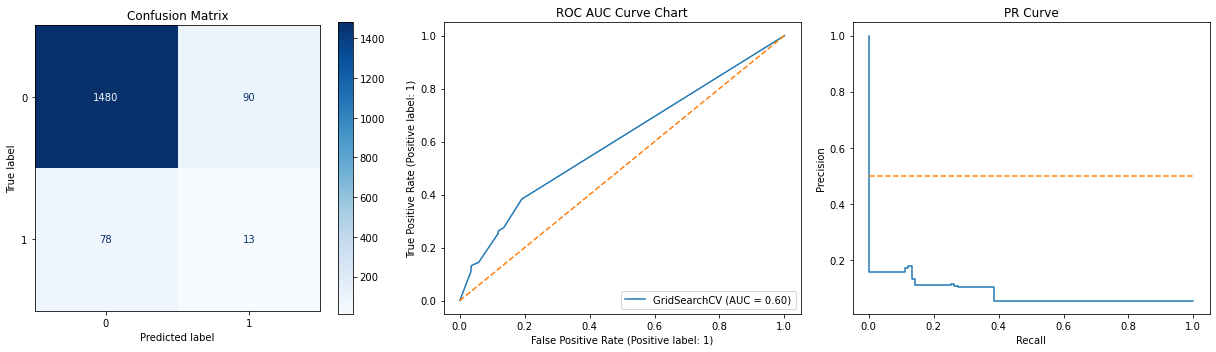

In [54]:
mod_metrics = metrics_and_plot_cm(gs_ada, Xs_val, y_val)

In [55]:
results_df = append_results(results_df,
                           gs_ada.score(Xs_train, y_train),
                           mod_metrics,
                           'AdaBoost',
                           )

In [56]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646
1,SVM,0.787747,0.754365,0.245635,0.670330,0.759236,0.138952,0.230189,0.795898,0.154321
2,PCA Logistic Regression,0.691254,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268
3,PCA SVM,0.787897,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268
4,AdaBoost,0.976366,0.898856,0.101144,0.142857,0.942675,0.126214,0.134021,0.599493,0.082134


# Predicting with Test Data

We utilise the whole train set as our train data here, and the test data to predict the probabilities, which will then be submitted to Kaggle for scoring.

In [57]:
X_train = pd.read_csv('./assets/X_train.csv')
y_train = pd.read_csv('./assets/y_train.csv')
X_test = pd.read_csv('./assets/test_final.csv')

In [58]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 50)

In [59]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0','index'], inplace=True)
X_test.set_index('id', inplace=True)

In [60]:
gs_logreg.fit(X_train, y_train)
gs_svc.fit(X_train, y_train)
gs_pca_logreg.fit(X_train, y_train)
gs_pca_svc.fit(X_train, y_train)
gs_ada.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100),
                                                           random_state=100))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [10], 'ada__n_estimators': [100],
                         'sampling__k_neighbors': [5],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             verbose=1)

In [61]:
output_results(gs_logreg.predict_proba(X_test), 'logreg_results')
output_results(gs_svc.predict_proba(X_test), 'svc_results')
output_results(gs_pca_logreg.predict_proba(X_test), 'pca_logreg_results')
output_results(gs_pca_svc.predict_proba(X_test), 'pca_svc_results')
output_results(gs_ada.predict_proba(X_test), 'ada_results')

# Final Model Summary

On running our 5 models above, we can see and compare the results. Additionally, we also submit our results using the test data on Kaggle, and compare it to our training scores. On reviewing the scores, we have chosen Logistic Regression as it is our best performing model.

In [75]:
kaggle_df = pd.DataFrame({
    'model':['Logistic Regression','SVM','PCA Logistic Regression','PCA SVM','AdaBoost'],
    'kaggle_score':[0.71124, 0.67628, 0.69644, 0.68752, 0.54166]
})
results_df = results_df.merge(kaggle_df, how='left', on='model')

In [76]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc,pr_score,kaggle_score
0,Logistic Regression,0.703598,0.692354,0.307646,0.692308,0.692357,0.115385,0.197802,0.768006,0.157646,0.71124
1,SVM,0.787747,0.754365,0.245635,0.670330,0.759236,0.138952,0.230189,0.795898,0.154321,0.67628
2,PCA Logistic Regression,0.691254,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268,0.69644
3,PCA SVM,0.787897,0.676701,0.323299,0.714286,0.674522,0.112847,0.194903,0.766512,0.154268,0.68752
4,AdaBoost,0.976366,0.898856,0.101144,0.142857,0.942675,0.126214,0.134021,0.599493,0.082134,0.54166


**Key Observations**

Logistic Regression
- Better sensitivity/recall compared to SVM.
- Has best better precision-recall score compared to other models
- "Cliffs" on PR-AUC chart has slightly more points nearer to 0.5 threshold

SVM
- Except for sensitivity and precision-recall score, has better scores compared to Logistic Regression

PCA Logistic Regression
- Performance is similar with PCA SVM

PCA SVM
- Performance is similar with PCA Logistic Regression

AdaBoost
- Has high accuracy, but very low sensitivity, precision, f1 score and precision-recall scores

Overall
- ROC AUC can show whether the model can perform well, but it might not give an obvious visualisation when there are imbalanced classes within the dataset
- SMOTE may generate new samples based on target class and nearest neighbors, which may also generate replicas on the majority class


<hr style="border:2px solid gray"> </hr>

# Feature Importance

Here, we look closer at the important features based on the coefficients from our Logistic Regression model, to better understand the features that contributed strongly to the predictions.

In [63]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': gs_logreg.best_estimator_[1].coef_[0]})

# top 20 features
logreg_features = logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

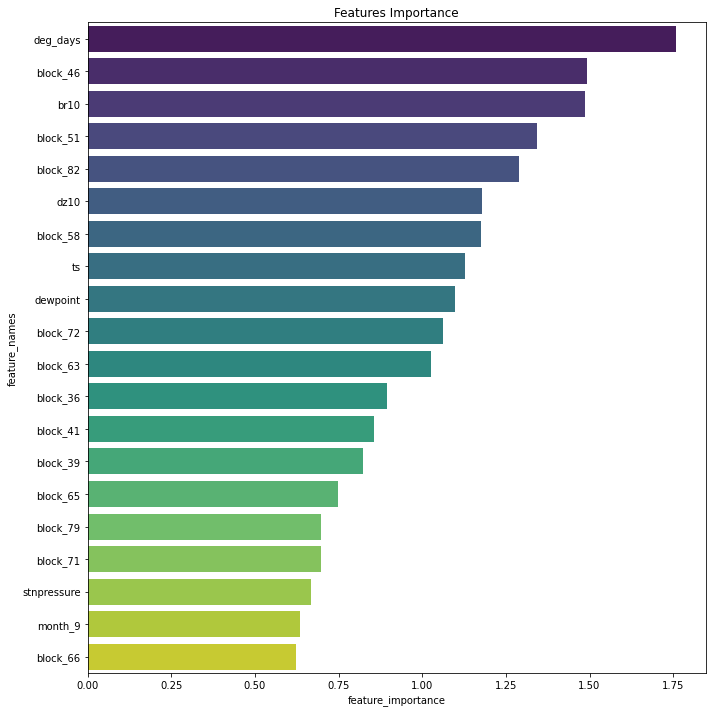

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=logreg_features, y='feature_names', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

In examining feature importance, some of the top indicators of West Nile Virus occurrence, are `deg_days` and whether there has been a drizzle in the last 10 days. The first of these, has been correlated with mosquito activity in literature and its presence should be of no surprise. However, its rank here does reiterate its importance.

The next top features that are not blocks, are weather features. Specifically, 2 engineered features, if it drizzled or was misty 10 days ago, both good importance, as earlier speculated. This coincides with the idea that mosquito life cycle in Summer in Chicago may be shorted at 10 days, and that the stagnant water for the moisture may account for mosquito breeding. This is further reinforced by the appearance of thunderstorms as a feature, and station pressure, as incoming weather systems would increase the barometric pressure measured.

Lastly, we do see that specific blocks in the city are much more likely to predict the occurrence of West Nile Virus. This may point to issues with stagnant water in specific areas of the city, leading to a more breading areas, or perhaps areas with inhabitants more susceptible to the West Nile Virus.

# Cost Benefit Analysis

In effective pest management, one should consider the use of different spray types and effectiveness, as well as factors influencing the lifecycle of the pest.

When considering only fogging, the typical spray used in residential areas for combating mosquitos, timing of the spray should be strongly considered in reducing a mosquito population due to its time-constrained effectiveness:
1. Timing of rainfall
* Rainfall can have a large impact on the population of mosquitos, with stagnant, trapped water providing fertile breeding ground. In built-up cities such as Chicago, it can be difficult to get rid of all water traps and to completely eliminate sources of stagnant water. Use of fogging 8-10 days after a heavy downpour can be a timely way to eliminate mosquito populations for the day, as they are hatching, and accurately target the spray to its window of maximum effectiveness.

* Spray use should also be avoided when the timing coincides with predictions of rainfall on the day itself. For maximum effectiveness, sprays would have to remain in the air and interact with the mosquito population. Any precipitation during the course of the day would reduce the effectiveness of the spray by taking it out of the air and preventing maximum exposure.

2. Degree Days
* Mosquitos have shown to be most active around a specific temperature band, above 65F, often measured in degree days. When judging appropriate spray effectiveness, degree days can be used to help judge the use and timing of sprays. More days consistently above the 65F band would lead to a faster lifecycle, and a more active population, requiring a more consistent use of spraying. In contrast, we may avoid spraying on cooler days due to the limited effectivness of spraying, particularly when the mosquito population is small. Targeted use specifically in areas that have historically had the West Nile Virus presence can be considered instead.
* In examining our spray data set, sprays have largely been applied in September. This might be one big area of improvement for future spray applications, to shift them towards the summer months, when mosquitos are most active.

3. Wind Speed and Drift
* Wind speed should also be considered on the day of application. Wind speed can cause pesticide drift, removing the pesticide fog from its most effective location. Wind speed of the day should be considered during pesticide application. This is especially important in Chicago, which follows a grid layout, allowing buildings to form wind corridors and exacerbating wind effects. 
* Conversely, days with no wind speed can be difficult for spray operators, at speeds below 3km/h, spray can evaporate before arriving at the desired destination of application. A light breeze will provide the operator with the knowledge of the pesticide drift.

4. Sprayer Type
* Sprayer machinery can play an important role in the application of pesticides. A fine nozzle sprayer will help to provide a fine dispersion of the pesticide mist, however, hot days and lower humidity can lead to a faster evaporation of smaller droplets. Conversely, larger particle sizes (>200 microns) may survive the heat and be less affected by wind size, but may not be as effective at delivering the pesticide to pests.

5. Pesticide
* The assumption made is that the spray used is the most commonly use spray for fogging the air and targeting adult mosquitoes. However, standing pesticides can also be used in conjunction with air pesticides, targeting difficult to reach or difficult to clear areas with standing water to eliminate mosquito larvae. This would be a far more long-reaching solution, although constant re-application would be required through each rainfall. Therefore, consideration would have to be given according to the frequency of rainfall and the difficulty of application.

## Model 1

### Costs

Spraying Costs

For our first model, we will look at a widespread spraying of the city.

- [Time of spray](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html): Weather permitting, the spraying will begin at dusk on August 13th and continue through the night until approximately 1:00 am, with licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. The material being used to control the adult mosquitoes, Zenivex.


- [Spray rate of Zenivex](https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/): The chemical used is Zenivex, applied at a rate of 1.5 fluid ounces per acre. That measure is approved by the U.S. EPA to control mosquitoes in outdoor residential and recreational areas.


- [Zenivex cost per acre](https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/zenivex%20cost%20comparison%20fact%20sheet.pdf): USD0.67 per acre



- Area of Chicago City: estimated to be 145,300 acres based on Google Search

Based on the above, we assume the cost of spray to be USD 0.67 per acre multiplied by the area of Chicago city. This will account for 1 spraying exercise.

In [65]:
# cost of 1 spraying exercise
spray_cost = 145300*0.67
spray_cost

97351.0

We will estimate the cost of 1 spraying exercise to be about USD 97,351.

If we assume the most aggressive spray strategy and spray every week during the summer months of July, August and September based on our spray effectiveness analysis in the previous notebook, then the total cost can be calculated to be:

In [66]:
# total cost of spraying annually
# assuming each spray * 4 weeks * 3 months
spray_cost * 4 * 3

1168212.0

For this scenario, we would need to set aside a budget of about USD 1.17 million to conduct the spraying exercises on an annual basis.

### Benefits

In a maximum benefit scenario, we assume that due to our aggressive spraying policy, no one contracted the virus.

Conversely, in a scenario where the spray had not been used, we will use the following costs:

Medical Health Costs

  - Number of [human WNV cases](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/) in Chicago region will be taken as the average of cases from 2007-2014 (same as our dataset), without the years of 2011 and 2013, to determine maximal benefit against a programme with no spraying

In [67]:
wnv_cases = [43, 10, 1, 47, 229, 31]
print(np.mean(wnv_cases))

60.166666666666664


  - The [CDC estimates](https://www.sciencedaily.com/releases/2014/02/140210184713.htm):
     - Roughly 4 out of 5 people are asymptomatic
     - 1 in 5 people who are infected develop a fever, with a median medical cost of USD 7,500
     - 1 in 150 infected people develop a serious, sometimes fatal, illness incurring long-term median medical costs of a total of USD 47,000.

In [68]:
print(f'The medical costs for symptomatically mild to moderate cases are USD {60/5 * 7500}.')
print(f'The medical costs for symptomatically severe cases, rounding up, are USD {1 * 47000}.')
print('------------')
print('\nThe total medical costs are USD 137,000')

The medical costs for symptomatically mild to moderate cases are USD 90000.0.
The medical costs for symptomatically severe cases, rounding up, are USD 47000.
------------

The total medical costs are USD 137,000


Productivity Loss

Based on [NCBI(National Centre for Biotechnology Information)'s study in determining productivity loss of an individual](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) , we assume productivity loss to be (referenced from Table 3 in the link):


In [69]:
# Estimated economic costs of WNV cases due to productivity loss, proxy from a study in California
print('For the symptomatically mild and moderate cases:\n')
print(f'USD {955} for each individual, for a total of USD {955 * 12}')
print('------------------------------')
print('For the hospitalised individual:\n')
print('USD 10800, if the individual is under the age of 60')
print('------------------------------')
print(f'Total productivity loss: USD {11460 + 10800}')

For the symptomatically mild and moderate cases:

USD 955 for each individual, for a total of USD 11460
------------------------------
For the hospitalised individual:

USD 10800, if the individual is under the age of 60
------------------------------
Total productivity loss: USD 22260


The economic loss to WNV can be calculated as USD 159,260.

The prevention of economic loss of USD 159,260 does not, however, justify the spending of USD 1.17 million to spray pesticides.

## Model 2

In our second model, we look to target specific areas of the city, highly affected by the mosquitos, along with the following factors:

- Spray Area: Spray Area imputed from the spray area of the 2011 spray block, an area roughly measuring 12.857 km^2, or 3177 acres.

- Spray Times: Following the EDA done on the weather data set, alongside the features that were deemed to be of the highest importance in the logistic regression, we can see that spraying can be targeted to hit the life cycle of mosquitos immediately after periods that are:
    1. At least 10 days after a light rain or mist event
    2. On days where the degree day value is 7 or higher
    
Assuming this happens 3 times a month (Every 10 days of uninterupted sunshine following a rain event), and only in the months correlated with the highest number of cases (August, September), we can lower spray frequency to 6 times a year.

Further, from our EDA, only 18 of the 64 blocks in the train set had WNV counts above 10 for the last 4 years, more than 2.5 cases per year per block.

Therefore, we would restrict our spraying to only the regions that would benefit the most.

At a rate of:
* 6 sprays a year
* For 18 blocks * 3177 acres * USD 0.67 per acre

The total cost of Model 2 would be:

In [70]:
print(6*18*3177*0.67)

229887.72


At USD 230,000, this spray plan is remains higher than the loss estimated of USD 159,260.

# Recommendations

In conclusion, while a model that included indiscriminate spraying through Chicago did not show material benefit when compared to the cost, a model that was calculated based on initial features discovered during EDA and examined after modeling did product a spray plan that was more expensive than the economic loss estimated.

This model was however based on a worst case scenario of 6 sprays. When adjusted by the weather for the year, it will likely reduce the reliance of such a high spray count. Further streamlining of the model could be done by looking at the month of June as a lead up, to help determine the severity of the mosquito population for the year.

That said, the [best and most economical way](https://www.cdc.gov/westnile/prevention/index.html) to prevent West Nile disease or any other mosquito-borne illness is likely education of the populace, to reduce the number of mosquitoes. Precautions recommended by the CDC include:

- When outdoors, apply insect repellent that contains DEET, picaridin, oil of lemon eucalyptus or IR 3535, according to label instructions.
- Wear long-sleeved shirts and long pants when going out
- Make sure doors and windows have tight-fitting screens. Repair or replace screens that have tears or other openings. Try to keep doors and windows shut, especially at night.
- Eliminate sources of water-holding containers that can support mosquito breeding such as tires, buckets, planters, toys, pools, birdbaths, flowerpots, or trash containers
- In communities where there are organized mosquito control programs, contact your municipal government to report areas of stagnant water in roadside ditches, flooded yards and similar locations that may produce mosquitoes.

# Further Steps

Some things to consider in a follow-up model or test sets, would include data on the following:
- Use models with class weights. This will penalise the misclassifications made by the minority class by setting a higher class weight , and at the same time, reducing weight for the majority class. Penalising mistakes will put more emphasis on the misclassifed class.
- Consider other approaches in dealing with imbalanced classification, such as ADASYN
- Collect more data to balance classes within the dataset.